In [1]:
"""
this script contains functions to visualize the different attributes
Author: Nathan Greffe
"""
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
from collections import OrderedDict
from matplotlib.lines import Line2D
import itertools

In [2]:
results = pd.read_csv('architectures.csv')
results = results[np.logical_not(results.acc3.isnull())]
results.reset_index(inplace=True)
results['time'] = results['time'] * 1000
results['error'] = 100*(1.0 - results[['acc1', 'acc2', 'acc3']].mean(axis=1))
results['error_std'] = 100*results[['acc1', 'acc2', 'acc3']].std(axis=1)
is_KD = results.file_name.apply(lambda x: "_KD" in x)
is_new_KD = results.file_name.apply(lambda x: "newKD" in x)
results_KD = results[is_KD]
results_KD.reset_index(inplace=True)
results_new_KD = results[is_new_KD]
results_new_KD.reset_index(inplace=True)
results = results[np.logical_not(np.logical_or(is_KD, is_new_KD))]
results.reset_index(inplace=True)
results.head()

,level_0,index,file_name,arch,depth,width,other,se,acc1,acc2,acc3,time,error,error_std
0,0,0,squeezenext_d9_w48_cosine,squeezenext,9,48,NaN,NaN,0.9168,0.9184,0.9049,52.7,8.663333,0.737586
1,1,1,effnet_d12_w32_e4_cosine,effnet,12,32,4.0,NaN,0.9035,0.9080,0.9030,21.5,9.516667,0.275379
2,2,2,shufflenetv1_d9_w80_g2_cosine,shufflenetv1,9,80,2.0,NaN,0.9107,0.9057,0.9048,50.7,9.293333,0.317857
3,3,3,shufflenetv2_d12_w64_cosine,shufflenetv2,12,64,NaN,NaN,0.9238,0.9242,0.9230,44.1,7.633333,0.061101
4,4,4,shufflenetv2_d18_w80_cosine,shufflenetv2,18,80,NaN,NaN,0.9347,0.9373,0.9345,93.0,6.450000,0.156205


In [3]:
results_val = pd.read_csv('architectures_val.csv')
results_val['time'] = results_val['time'] * 1000
results_val['error'] = 100*(1.0 - results_val['acc'])
results_val.head()

,file_name,arch,depth,width,other,acc,time,error
0,effnet_d12_e2_cosine,effnet,12,2,NaN,0.8902,10.2,10.98
1,effnet_d12_e3_cosine,effnet,12,32,3.0,0.9038,15.3,9.62
2,effnet_d12_e4_cosine,effnet,12,32,4.0,0.9102,21.5,8.98
3,effnet_d15_e2_cosine,effnet,15,2,NaN,0.8888,10.1,11.12
4,effnet_d15_e3_cosine,effnet,15,32,3.0,0.8964,15.4,10.36


In [4]:
pruning_wrn_res = pd.read_csv('../NetAdapt/pruning_methods.csv')
pruning_wrn_res['table_time'] = pruning_wrn_res['table_time'] * 1000
pruning_wrn_res['measured_time'] = pruning_wrn_res['measured_time'] * 1000
pruning_wrn_res = pruning_wrn_res[np.logical_or(
    pruning_wrn_res.method == 'unpruned',
    np.logical_and(pruning_wrn_res.method == 'fisher_table', 
    pruning_wrn_res.criterion.isnull()))]  # we take the unpruned + fisher table WRNs
pruning_wrn_res.head()

,file_name,no_fine_tune,fine_tune,retrain_scratch,table_time,measured_time,method,criterion
39,res-40-2-table_fisher-pf=0.8-150ch,5.28,NaN,4.97,284.2,285.6,fisher_table,NaN
40,res-40-2-table_fisher-pf=0.8-300ch,5.39,NaN,5.25,243.1,240.4,fisher_table,NaN
41,res-40-2-table_fisher-pf=0.8-450ch,5.29,NaN,5.36,220.5,222.0,fisher_table,NaN
42,res-40-2-table_fisher-pf=0.8-600ch,7.52,NaN,5.71,168.6,166.8,fisher_table,NaN
43,res-40-2-table_fisher-pf=0.8-750ch,15.80,NaN,5.92,119.3,117.9,fisher_table,NaN


In [5]:
# fits a polynom
polynom = np.poly1d(np.polyfit(pruning_wrn_res.measured_time, 
                               pruning_wrn_res.retrain_scratch, 4))

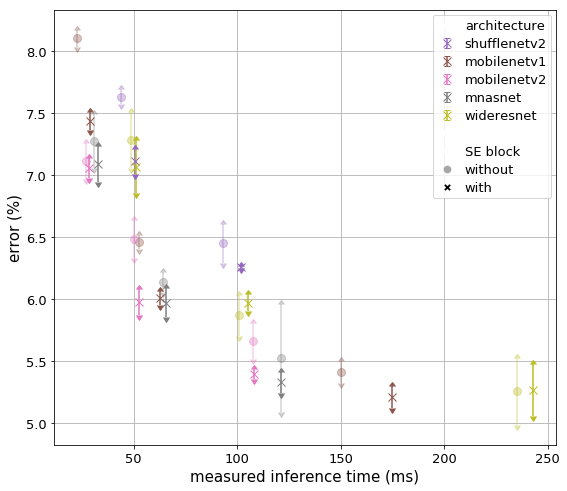

In [6]:
displays_SE = True
displays_WRN = False

_, idx = np.unique(results.arch, return_index=True)
color_labels = results.arch[np.sort(idx)]
rgb_values = sns.color_palette(n_colors=color_labels.shape[0]+1)[1:]  # skips blue which is 
# already used
color_map = dict(zip(color_labels, rgb_values))
colors = results.arch.map(color_map)

fig, ax = plt.subplots(1, figsize=(9, 8))
if displays_WRN:
    sns.scatterplot(x="measured_time", y="retrain_scratch", data=pruning_wrn_res, legend='brief', 
                    ax=ax, s=60)
# plt.plot(np.arange(35,351,15), polynom(np.arange(35,351,15)))
for i in range(results.shape[0]):
    if (displays_SE or ('se' not in results.file_name[i])) and \
    (not displays_SE or results.arch[i] not in ['squeezenext', 'effnet', 'shufflenetv1']):  
        # do not displays SE when displays_SE == False and do not show bad arch. when SE == True
        plt.errorbar(results.time[i], 
                     results.error[i],
                     color=colors[i],
                     yerr=results.error_std[i],
                     fmt='x' if 'se' in results.file_name[i] else 'o', 
                     lolims=True, uplims=True,
                     markersize=8, 
                     alpha=.35 if displays_SE and 'se' not in results.file_name[i] else 1,
                     ecolor=colors[i],
                     label=results.arch[i])
ax.set_xlabel('measured inference time (ms)', fontsize=15)
ax.set_ylabel('error (%)', fontsize=15)
ax.grid(True)

handles, labels = plt.gca().get_legend_handles_labels()  # removes duplicates

if displays_SE:
    by_label = OrderedDict(zip(labels, handles))
else:
    by_label = OrderedDict(zip(labels[::-1], handles[::-1])) # so as to have rounds or 
    # crosses in the legend

labels = [i for i in by_label.keys()]
handles = [i for i in by_label.values()]

if displays_SE:
    handles.append(Line2D([0], [0], marker='o', color='w', label='',
                              markerfacecolor='w', markersize=8))
    labels.append('')

    handles.append(Line2D([0], [0], marker='o', color='w', label='',
                              markerfacecolor='w', markersize=8))
    labels.append('SE block')

    handles.append(Line2D([0], [0], marker='o', color='w', label='with',
                              markerfacecolor='k', alpha=0.35, markersize=8))
    labels.append('without')

    handles.append(Line2D([0], [0], marker='X', color='w', label='retrain_scratch',
                              markerfacecolor='k', markersize=8))
    labels.append('with')
    
if displays_WRN:
    handles.append(Line2D([0], [0], marker='o', color='w', label='',
                              markerfacecolor='C0', markersize=8))
    labels.append('WRN (fisher_table pruning)')
    
handles = [Line2D([0], [0], marker='o', color='w', label='',
                              markerfacecolor='w' , markersize=8)] + handles
labels = ['architecture'] + labels

ax.legend(handles, labels)
plt.setp(ax.get_legend().get_texts(), fontsize='13') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='14') # for legend title
ax.tick_params(axis='both', which='major', labelsize=13)  # for ticks
# plt.savefig(f'arch_comparison{"_SE" if displays_SE else "_WRN" if displays_WRN else ""}.pdf')

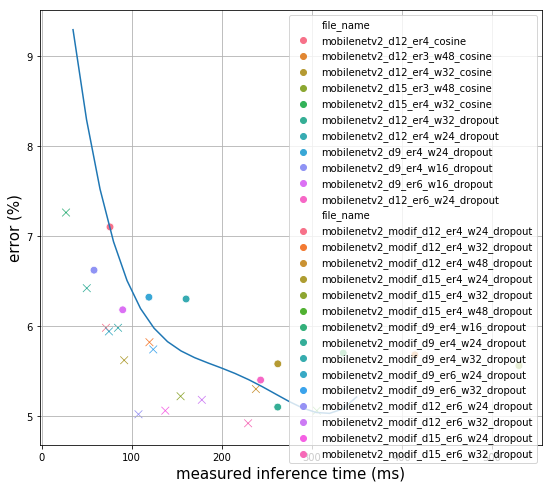

In [7]:
fig, ax = plt.subplots(1, figsize=(9, 8))
offset_modif = results_val[results_val.arch == "mobilenetv2"].apply(lambda x: 'modif' in x.file_name, axis=1)
results_val_to_plot = results_val[results_val.arch == "mobilenetv2"][np.logical_not(offset_modif)]
sns.scatterplot(x="time", y="error", data=results_val_to_plot, hue='file_name', 
                legend='brief', ax=ax, s=60, marker='o')
results_val_to_plot = results_val[results_val.arch == "mobilenetv2"][offset_modif]
sns.scatterplot(x="time", y="error", data=results_val_to_plot, hue='file_name', 
                legend='brief', ax=ax, s=60, marker='x')
plt.plot(np.arange(35,351,15), polynom(np.arange(35,351,15)))
ax.set_xlabel('measured inference time (ms)', fontsize=15)
ax.set_ylabel('error (%)', fontsize=15)
ax.grid(True)

In [8]:
def make_KD_plot(teacher, students, labels, save_file=None):
    """makes a plot representing the knowledge distillation process for a given net, 
    students must be sorted, from the bigger to the smaller"""
    N = students.shape[0] + 1
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35       # the width of the bars


    fig, ax = plt.subplots(1, figsize=(9, 8))
    KD = ax.bar(ind, np.insert(students.error_KD.values, 0, 0), width, 
                yerr=np.insert(students.error_std_KD.values, 0, 0))

    no_KD = ax.bar(ind+width, np.insert(students.error_noKD.values, 0, 0), width, 
                   yerr=np.insert(students.error_std_noKD.values, 0, 0))
    teacher = ax.bar(width/2, teacher.error.values, width, yerr=teacher.error_std.values)

    # add some
    ax.set_xlabel('network', fontsize=15)
    ax.set_ylabel('error (%)', fontsize=15)
    ax.grid(True, axis='y')
    ax.set_ylim((4, 7.7))
    ax.set_axisbelow(True)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(labels)

    ax.legend((KD[0], no_KD[0], teacher[0]), ('KD pipeline', 'no KD', 'teacher'), loc='upper left')
    plt.setp(ax.get_legend().get_texts(), fontsize='13') # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize='14') # for legend title
    ax.tick_params(axis='both', which='major', labelsize=13)  # for ticks

    if save_file is not None:
        plt.savefig(save_file)
        plt.show()

In [9]:
results_KD_noKD = results_KD.merge(results, on=["arch", "time"], suffixes=("_KD", "_noKD"))
results_KD_noKD[["file_name_KD", "arch", "depth_KD", "width_KD", "error_KD", "error_std_KD", "error_noKD", "error_std_noKD"]]

,file_name_KD,arch,depth_KD,width_KD,error_KD,error_std_KD,error_noKD,error_std_noKD
0,mobilenetv1_d15_w32_se2_cosine_KD_t2_l02,mobilenetv1,15,32,7.343333,0.265016,7.440000,0.072111
1,mobilenetv1_d12_w64_se2_cosine_KD_t2_l02,mobilenetv1,12,64,5.833333,0.151438,6.006667,0.056862
2,mobilenetv1_d15_w100_se2_cosine_KD_t2_l02,mobilenetv1,15,100,5.083333,0.005774,5.213333,0.090738
3,mobilenetv2_d12_er6_w24_se2_dropout_KD_t2_l02,mobilenetv2,12,24,5.453333,0.221209,5.400000,0.040000
4,mobilenetv2_d9_er4_w24_se2_dropout_KD_t2_l02,mobilenetv2,9,24,6.190000,0.174356,5.980000,0.105830
5,mobilenetv2_d9_er4_w16_se2_dropout_KD_t2_l02,mobilenetv2,9,16,7.183333,0.245832,7.056667,0.080208
6,mnasnet_d12_er6_w24_se2_dropout_KD_t2_l02,mnasnet,12,24,5.323333,0.061101,5.330000,0.087178
7,mnasnet_d12_er6_w16_se2_dropout_KD_t2_l02,mnasnet,12,16,6.146667,0.168622,5.973333,0.115036
8,mnasnet_d9_er4_w16_se2_dropout_KD_t2_l02,mnasnet,9,16,7.033333,0.205994,7.090000,0.144222
9,res_d22_w16_KD_t2_l02,wideresnet,22,16,7.253333,0.307300,7.283333,0.223681


In [10]:
teacher = results_KD[results_KD.file_name.apply(lambda x: x == "wideresnet_40_4_se2_for_KD")]
teacher

,level_0,index,file_name,arch,depth,width,other,se,acc1,acc2,acc3,time,error,error_std
9,34,34,wideresnet_40_4_se2_for_KD,wideresnet,40,4,NaN,2.0,0.9576,0.9568,0.9556,NaN,4.333333,0.100664


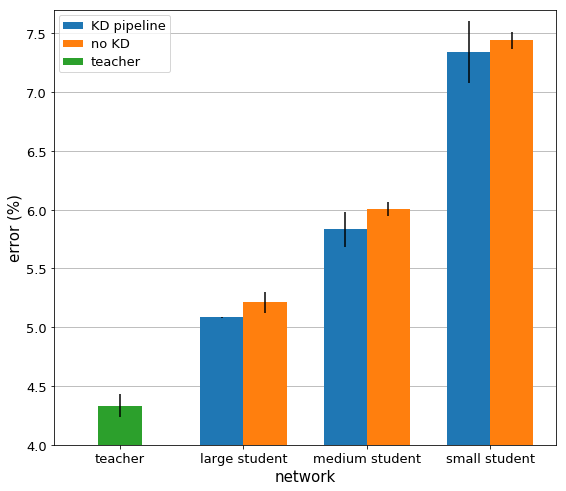

In [11]:
net = "mobilenetv1"

student = results_KD_noKD[np.equal(results_KD_noKD.arch, net)].sort_values("time", ascending=False)
labels = ("teacher", "large student", "medium student", "small student")
make_KD_plot(teacher, student, labels)#, save_file=f"KD_comp_{net}.pdf")

In [12]:
test_KD = pd.read_csv('test_KD.csv')
test_KD['error'] = 100*(1.0 - test_KD[['acc1', 'acc2', 'acc3']].mean(axis=1))
test_KD['error_std'] = 100*test_KD[['acc1', 'acc2', 'acc3']].std(axis=1)
test_KD.head()

,name,net,KD_pipeline,acc1,acc2,acc3,time,error,error_std
0,res-10-base,res-10,False,0.8928,0.8930,0.8925,0.0164,10.723333,0.025166
1,res-22-base,res-22,True,0.9265,0.9264,0.9268,0.0490,7.343333,0.020817
2,res-16-KD,res-16,True,0.9287,0.9226,0.9255,0.0325,7.440000,0.305123
3,res-16-base,res-16,False,0.9216,0.9186,0.9187,0.0325,8.036667,0.170392
4,res-10-KD,res-10,True,0.9035,0.9003,0.9012,0.0164,9.833333,0.165025


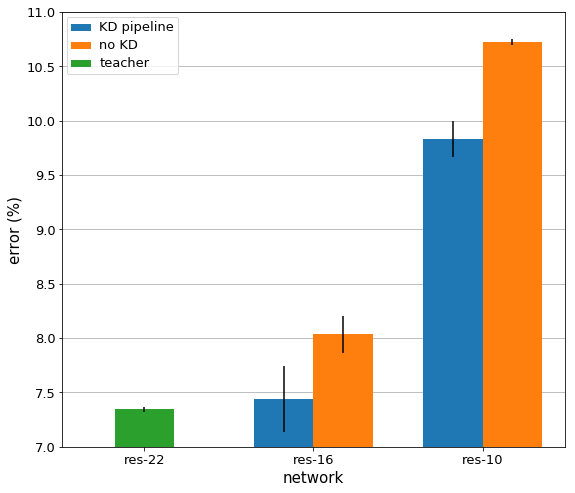

In [13]:
KD_pipeline = test_KD[test_KD.KD_pipeline].sort_values("net", ascending=False)
base_net = test_KD[np.logical_not(test_KD.KD_pipeline)].sort_values("net", ascending=False)

N = KD_pipeline.shape[0]
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars


fig, ax = plt.subplots(1, figsize=(9, 8))
KD = ax.bar(ind, np.insert(KD_pipeline.error.values[1:], 0, 0), width, 
            yerr=np.insert(KD_pipeline.error_std.values[1:], 0, 0))  # the first element 
# of KD_pipeline is the teacher

no_KD = ax.bar(ind+width, np.insert(base_net.error.values, 0, 0), width, 
                yerr=np.insert(base_net.error_std.values, 0, 0))

teacher = ax.bar(width/2, KD_pipeline.error.values[0:1], width, 
                yerr=KD_pipeline.error_std.values[0:1])

# add some
ax.set_xlabel('network', fontsize=15)
ax.set_ylabel('error (%)', fontsize=15)
ax.grid(True, axis='y')
ax.set_ylim((7, 11))
ax.set_axisbelow(True)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(KD_pipeline.net)

ax.legend((KD[0], no_KD[0], teacher[0]), ('KD pipeline', 'no KD', 'teacher'))
plt.setp(ax.get_legend().get_texts(), fontsize='13') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='14') # for legend title
ax.tick_params(axis='both', which='major', labelsize=13)  # for ticks

# plt.savefig('KD_test.pdf')
plt.show()

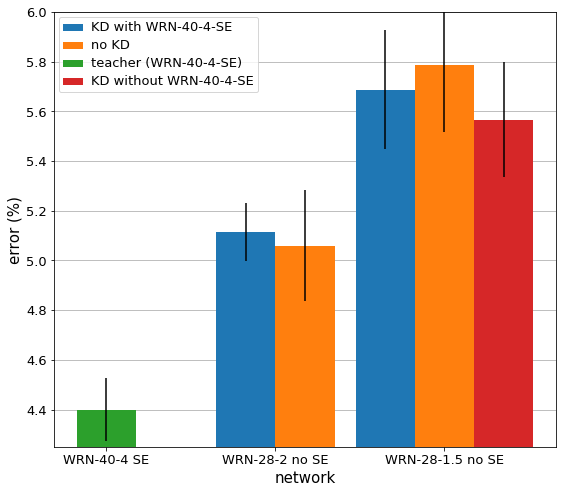

In [14]:
test_KD2 = pd.read_csv('test_KD_2.csv')
test_KD2['error'] = 100*(1.0 - test_KD2[['acc1', 'acc2', 'acc3']].mean(axis=1))
test_KD2['error_std'] = 100*test_KD2[['acc1', 'acc2', 'acc3']].std(axis=1)
test_KD2.sort_values("group", inplace=True)
KD_teach = test_KD2[test_KD2.pipeline.apply(lambda x: x == "KD_teach")]
KD_no_teach = test_KD2[test_KD2.pipeline.apply(lambda x: x == "KD_no_teach")]
no_KD = test_KD2[test_KD2.pipeline.apply(lambda x: x == "no_KD")]
teacher = test_KD2[test_KD2.pipeline.apply(lambda x: x == "teacher")]

N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars


fig, ax = plt.subplots(1, figsize=(9, 8))
KD = ax.bar([1, 2-width/2], KD_teach.error.values, width, 
            yerr=KD_teach.error_std.values)

no_KD = ax.bar([1+width, 2+width/2], no_KD.error.values, width, 
                yerr=no_KD.error_std.values)

teacher = ax.bar(width/2, teacher.error.values, width, 
                yerr=teacher.error_std.values)

KD_no_teach = ax.bar(2+ 1.5*width, KD_no_teach.error.values, width, yerr=KD_no_teach.error_std.values)

# add some
ax.set_xlabel('network', fontsize=15)
ax.set_ylabel('error (%)', fontsize=15)
ax.grid(True, axis='y')
ax.set_ylim((4.25, 6))
ax.set_axisbelow(True)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('WRN-40-4 SE', 'WRN-28-2 no SE', 'WRN-28-1.5 no SE'))

ax.legend((KD[0], no_KD[0], teacher[0], KD_no_teach[0]), ('KD with WRN-40-4-SE', 'no KD', 'teacher (WRN-40-4-SE)', 'KD without WRN-40-4-SE'), loc='upper left')
plt.setp(ax.get_legend().get_texts(), fontsize='13') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='14') # for legend title
ax.tick_params(axis='both', which='major', labelsize=13)  # for ticks

# plt.savefig('KD_test2.pdf')
plt.show()

In [15]:
test_KD3 = pd.read_csv('test_KD_3.csv')
test_KD3['error'] = 100*(1.0 - test_KD3[['acc1', 'acc2', 'acc3']].mean(axis=1))
test_KD3['error_std'] = 100*test_KD3[['acc1', 'acc2', 'acc3']].std(axis=1)
test_KD3

,file_name,pipeline,acc1,acc2,acc3,error,error_std
0,mobilenetv1_d15_w100_cosine_KDnoT_t2_l02,teacher,0.9490,0.9462,0.9468,5.266667,0.147422
1,mobilenetv1_d12_w64_cosine_KDnoT_t2_l02,student,0.9432,0.9444,0.9386,5.793333,0.306159
2,mobilenetv1_d12_w64_cosine,no_KD,0.9384,0.9374,0.9336,6.353333,0.253246
3,mobilenetv1_d15_w100_se2_cosine_KDnoT_t2_l02,teacher,0.9484,0.9504,0.9452,5.200000,0.262298
4,mobilenetv1_d12_w64_se2_cosine_KDnoT_t2_l02,student,0.9472,0.9458,0.9428,5.473333,0.224796
5,mobilenetv1_d12_w64_se2_cosine,no_KD,0.9432,0.9440,0.9368,5.866667,0.394631
6,mobilenetv2_d12_er6_w24_dropout_newKD,teacher,0.9500,0.9474,0.9494,5.106667,0.136137
7,mobilenetv2_d9_er4_w24_dropout_newKD,student,0.9386,0.9346,0.9366,6.340000,0.200000
8,mobilenetv2_d9_er4_w24_dropout,no_KD,0.9342,0.9320,0.9356,6.606667,0.181475
9,mobilenetv2_d12_er6_w24_se2_dropout_newKD,teacher,0.9548,0.9464,0.9502,4.953333,0.420634


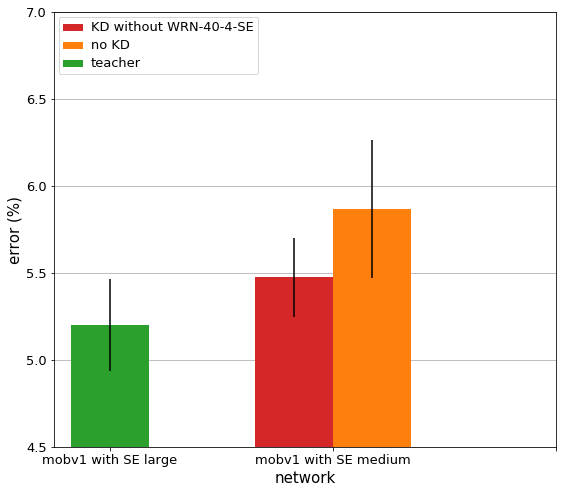

In [16]:
use_SE = True
use_mobv1 = True

offsets = test_KD3.file_name.apply(lambda x: "mobilenetv1" in x if use_mobv1 else "mobilenetv2" in x)
test_KD3 = test_KD3[offsets]

test_KD3 = test_KD3[test_KD3.file_name.apply(lambda x: "_se2_" in x if use_SE else "_se2_" not in x)]

student = test_KD3[test_KD3.pipeline.apply(lambda x: x == "student")]
no_KD = test_KD3[test_KD3.pipeline.apply(lambda x: x == "no_KD")]
teacher = test_KD3[test_KD3.pipeline.apply(lambda x: x == "teacher")]

width = 0.35       # the width of the bars


fig, ax = plt.subplots(1, figsize=(9, 8))
KD = ax.bar([1], student.error.values, width, 
            yerr=student.error_std.values, color='C3')

no_KD = ax.bar([1+width], no_KD.error.values, width, 
                yerr=no_KD.error_std.values, color='C1')

teacher = ax.bar(width/2, teacher.error.values, width, 
                yerr=teacher.error_std.values, color='C2')

# add some
ax.set_xlabel('network', fontsize=15)
ax.set_ylabel('error (%)', fontsize=15)
ax.grid(True, axis='y')
ax.set_ylim((4.5, 7))
ax.set_axisbelow(True)
ax.set_xticks(ind + width / 2)
msg = "with SE" if use_SE else "no SE"
net = "mobv1" if use_mobv1 else "mobv2"
ax.set_xticklabels((f'{net} {msg} large', f'{net} {msg} medium'))

ax.legend((KD[0], no_KD[0], teacher[0]), ('KD without WRN-40-4-SE', 'no KD', 'teacher'), loc='upper left')
plt.setp(ax.get_legend().get_texts(), fontsize='13') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='14') # for legend title
ax.tick_params(axis='both', which='major', labelsize=13)  # for ticks

# plt.savefig(f'KD_test3_{net}_{"SE" if use_SE else "noSE"}.pdf')
plt.show()

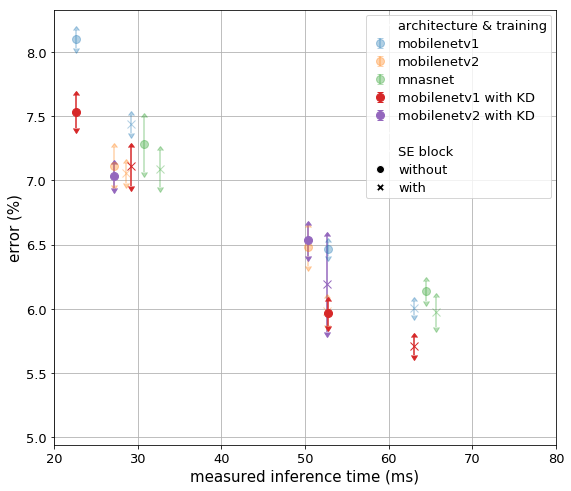

In [19]:
colors = {'mobilenetv1': 'C0',
         'mobilenetv2': 'C1',
         'mnasnet': 'C2',
         'mobilenetv1_KD': 'C3',
         'mobilenetv2_KD': 'C4'}

legend = {'mobilenetv1': 'mobilenetv1',
         'mobilenetv2': 'mobilenetv2',
         'mnasnet': 'mnasnet',
         'mobilenetv1_KD': 'mobilenetv1 with KD',
         'mobilenetv2_KD': 'mobilenetv2 with KD'}

fig, ax = plt.subplots(1, figsize=(9, 8))
results_mob = pd.concat([results[results.arch.apply(
    lambda x: x in ['mobilenetv1', 'mobilenetv2', 'mnasnet'])], results_new_KD])
results_mob.drop(['level_0', 'index'], axis=1, inplace=True)
results_mob.sort_values(["se"], inplace=True, ascending=True)
results_mob.reset_index(inplace=True)
marksize = 8

for i in range(results_mob.shape[0]):
    plt.errorbar(results_mob.time[i], 
                 results_mob.error[i],
                 color=colors[results_mob.arch[i]],
                 yerr=results_mob.error_std[i],
                 fmt='x' if 'se' in results_mob.file_name[i] else 'o', 
                 lolims=True, uplims=True,
                 markersize=marksize, 
                 alpha=1 if "KD" in results_mob.arch[i] else 0.35,
                 ecolor=colors[results_mob.arch[i]],
                 label=legend[results_mob.arch[i]])
ax.set_xlabel('measured inference time (ms)', fontsize=15)
ax.set_ylabel('error (%)', fontsize=15)
ax.grid(True)

handles, labels = plt.gca().get_legend_handles_labels()  # removes duplicates
by_label = OrderedDict(zip(labels, handles))


labels = [i for i in by_label.keys()]
handles = [i for i in by_label.values()]


handles.append(Line2D([0], [0], marker='o', color='w', label='',
                          markerfacecolor='w', markersize=marksize))
labels.append('')

handles.append(Line2D([0], [0], marker='o', color='w', label='',
                          markerfacecolor='w', markersize=marksize))
labels.append('SE block')

handles.append(Line2D([0], [0], marker='o', color='w', label='with',
                          markerfacecolor='k', markersize=marksize))
labels.append('without')

handles.append(Line2D([0], [0], marker='X', color='w', label='retrain_scratch',
                          markerfacecolor='k', markersize=marksize))
labels.append('with')
    
    
handles = [Line2D([0], [0], marker='o', color='w', label='',
                              markerfacecolor='w' , markersize=marksize)] + handles
labels = ['architecture & training'] + labels

ax.legend(handles, labels)
ax.set_xlim((20, 80))
plt.setp(ax.get_legend().get_texts(), fontsize='13') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='14') # for legend title
ax.tick_params(axis='both', which='major', labelsize=13)  # for ticks
# plt.savefig(f'arch_comparison_KD.pdf')